# Behavioral Pattern Discovery of Cognitive Load

Correlating engineered behavioral features with NASA-TLX to validate a cognitive-load gradient across three tasks and to surface interpretable behavioral indicators for modeling.

This notebook:
- Loads the processed dataset (`data/processed/modeling_dataset_ultrarealistic.csv`).
- Computes Pearson/Spearman correlations between features and TLX (overall and per-task).
- Visualizes correlation structure and key feature distributions.
- Summarizes findings and implications for subsequent modeling.


## Table of Contents

- Dataset Overview
- Feature Identification & Correlations
- Overall Correlations
- Per-Task Correlations
- Visualizations
- Feature Distributions
- Discussion & Conclusion


## Dataset Overview

In [1]:

import pandas as pd, numpy as np
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid')
DATA_CSV = Path('../../data/processed/modeling_dataset_ultrarealistic.csv')
OUT_FIG_DIR = Path('../../analysis/results')
OUT_FIG_DIR.mkdir(parents=True, exist_ok=True)
df = pd.read_csv(DATA_CSV)
print(f"Loaded {len(df)} rows with {df['participantId'].nunique()} participants")
df[['participantId','task_id','tlx']].head()


Loaded 75 rows with 25 participants


,participantId,task_id,tlx
0,p-0001,task_1_form,28.3
1,p-0001,task_2_product,40.0
2,p-0001,task_3_travel,71.7
3,p-0002,task_1_form,28.3
4,p-0002,task_2_product,33.3




- N = 75 task-level observations from 25 participants (each completed 3 tasks).
- Tasks: Task 1 (Form Entry, low difficulty), Task 2 (Product Exploration, medium), Task 3 (Travel Planning, high).
- Each row is a participant–task pair with a corresponding NASA-TLX workload score.
- Within-subjects design enables repeated-measures analyses across tasks.

Example pattern: each participant appears three times (one per task), and TLX scores generally increase from Task 1 → Task 2 → Task 3, reflecting the intended difficulty gradient.


## Feature Identification & Correlations
We compute Pearson and Spearman correlations between engineered behavioral features and NASA-TLX (overall), and per-task Pearson correlations for task-specific insights.

### Selecting Feature Columns

We separate metadata columns from engineered features. The list below (`feature_cols`) includes all behavioral indicators used for correlation analyses.


In [2]:

meta_cols = {'participantId','task_id','tlx','High_Load','shap_cluster'}
feature_cols = [c for c in df.columns if c not in meta_cols]
feature_cols


['form_hesitation_index',
 'form_error_rate',
 'form_efficiency',
 'zip_code_struggle',
 'filter_optimization_score',
 'decision_uncertainty',
 'exploration_breadth',
 'planning_time_ratio',
 'multitasking_load',
 'constraint_violation_rate',
 'budget_management_stress',
 'scheduling_difficulty',
 'recovery_efficiency',
 'action_density',
 'idle_time_ratio',
 'mouse_entropy_avg',
 'rapid_hovers',
 'drag_attempts',
 'trait_skill',
 'trait_cautious']

### Feature Groups

- Form Interaction Metrics: `form_hesitation_index`, `form_error_rate`, `form_efficiency`, `zip_code_struggle`
- Product Exploration & Filtering: `filter_optimization_score`, `decision_uncertainty`, `exploration_breadth`, `planning_time_ratio`, `rapid_hovers`
- Travel Planning & Multitasking: `multitasking_load`, `constraint_violation_rate`, `budget_management_stress`, `scheduling_difficulty`, `drag_attempts`, `recovery_efficiency`
- Universal Behavioral Metrics: `action_density`, `idle_time_ratio`, `mouse_entropy_avg`
- Trait-Level Individual Differences: `trait_skill`, `trait_cautious`

### Why Correlations?

- Validity Check: Do features relate to TLX as expected (e.g., more constraint violations → higher workload)?
- Predictive Utility: Identify the most informative features for downstream modeling and SHAP-based explanations.

Next, we compute correlation matrices, surface the top associated features, and visualize distributions across the three difficulty levels.


### Computing Correlations

Next, we compute Pearson and Spearman correlations between each feature and TLX. Results are assembled into tidy DataFrames (`pearson_df`, `spearman_df`) for downstream display and plotting.


In [3]:

# Compute correlations
pearson_results = []
spearman_results = []
for c in feature_cols:
    valid = df[['tlx', c]].dropna()
    if len(valid) < 3:
        pearson_results.append((c, np.nan, np.nan))
        spearman_results.append((c, np.nan, np.nan))
        continue
    r, p = stats.pearsonr(valid['tlx'], valid[c])
    rho, p2 = stats.spearmanr(valid['tlx'], valid[c])
    pearson_results.append((c, r, p))
    spearman_results.append((c, rho, p2))

pearson_df = pd.DataFrame(pearson_results, columns=['feature','pearson_r','pearson_p']).sort_values('pearson_r', key=abs, ascending=False)
spearman_df = pd.DataFrame(spearman_results, columns=['feature','spearman_rho','spearman_p']).sort_values('spearman_rho', key=abs, ascending=False)

pearson_df.head(12)


,feature,pearson_r,pearson_p
11,scheduling_difficulty,0.806616,2.449000e-18
9,constraint_violation_rate,0.803345,4.244861e-18
10,budget_management_stress,0.798239,9.815831e-18
8,multitasking_load,0.732570,1.755512e-13
17,drag_attempts,0.663771,8.546398e-11
12,recovery_efficiency,-0.618090,3.459285e-09
2,form_efficiency,-0.584846,3.592421e-08
0,form_hesitation_index,-0.533083,8.488532e-07
15,mouse_entropy_avg,0.532151,1.063193e-06
4,filter_optimization_score,-0.424735,1.621047e-04


### Highlights: Correlations with TLX

Strong positive (higher workload):
- Scheduling difficulty (r ≈ 0.81, p < 1e-17)
- Constraint violation rate (r ≈ 0.80, p < 1e-17)
- Budget management stress (r ≈ 0.80, p < 1e-17)
- Multitasking load (r ≈ 0.73, p < 1e-12)
- Additionally: drag attempts (r ≈ 0.66), mouse entropy (r ≈ 0.53)

Strong negative (lower workload):
- Recovery efficiency (r ≈ −0.62, p < 1e-8)
- Form efficiency (r ≈ −0.58, p < 1e-7)
- Form hesitation index (r ≈ −0.53, p < 1e-6)

Interpretation:
- Task 3 (Travel Planning) features reflect scheduling pressure, constraint violations, and budget stress → higher TLX.
- Task 1 (Form Entry) efficiency features capture smoother, lower-load behavior → lower TLX.
- Task 2 (Product Exploration) shows moderate associations: filter optimization (r ≈ −0.42), planning time ratio (r ≈ 0.38), rapid hovers (r ≈ 0.20, ns).


### Overall correlations
Below we present the strongest correlations between engineered features and reported cognitive load (NASA-TLX).

#### Top Overall Associations (preview)

The next cell prints the top features by absolute Pearson correlation with TLX, including correlation coefficients and p-values.


In [4]:

top_overall = pearson_df.head(8)
for idx, row in top_overall.iterrows():
    feat = row['feature']; r = row['pearson_r']; p = row['pearson_p']
    direction = 'positively' if r > 0 else 'negatively'
    print(f"Feature '{feat}' is {direction} correlated with TLX: r = {r:.2f}, p = {p:.3g}.")


Feature 'scheduling_difficulty' is positively correlated with TLX: r = 0.81, p = 2.45e-18.
Feature 'constraint_violation_rate' is positively correlated with TLX: r = 0.80, p = 4.24e-18.
Feature 'budget_management_stress' is positively correlated with TLX: r = 0.80, p = 9.82e-18.
Feature 'multitasking_load' is positively correlated with TLX: r = 0.73, p = 1.76e-13.
Feature 'drag_attempts' is positively correlated with TLX: r = 0.66, p = 8.55e-11.
Feature 'recovery_efficiency' is negatively correlated with TLX: r = -0.62, p = 3.46e-09.
Feature 'form_efficiency' is negatively correlated with TLX: r = -0.58, p = 3.59e-08.
Feature 'form_hesitation_index' is negatively correlated with TLX: r = -0.53, p = 8.49e-07.


### Interpretation: Overall Correlations

High-load indicators (strong positive correlations):
- Scheduling difficulty (r ≈ 0.81)
- Constraint violations (r ≈ 0.80)
- Budget management stress (r ≈ 0.80)
- Multitasking load (r ≈ 0.73)
- Drag attempts (r ≈ 0.66)

These reflect the complexity of Task 3 (Travel Planning): higher behavioral difficulty corresponds to higher TLX.

Low-load indicators (negative correlations):
- Recovery efficiency (r ≈ −0.62)
- Form efficiency (r ≈ −0.58)
- Form hesitation (r ≈ −0.53)

These reflect smoother performance typical of Task 1 (Form Entry): more efficient behavior corresponds to lower TLX.

Moderate / weak correlations (Task 2 relevance):
- Filter optimization score (r ≈ −0.42)
- Planning time ratio (r ≈ 0.38)
- Rapid hovers (r ≈ 0.20, ns)

Overall, the pattern aligns with the intended difficulty gradient (Task 1 < Task 2 < Task 3) and highlights interpretable behavioral signals of workload.


## Per-task correlations
We compute Pearson correlations between each feature and TLX within each task to identify task-specific predictors.

### Computing Per-Task Correlations

We compute Pearson correlations within each task to identify task-specific predictors. The output table preview lists correlations and sample sizes per feature and task.


In [5]:

per_task_records = []
for task in df['task_id'].unique():
    sub = df[df['task_id']==task]
    for c in feature_cols:
        valid = sub[['tlx', c]].dropna()
        if len(valid) < 3:
            r = np.nan; p = np.nan
        else:
            r, p = stats.pearsonr(valid['tlx'], valid[c])
        per_task_records.append({'task_id': task, 'feature': c, 'pearson_r': r, 'pearson_p': p, 'n': len(valid)})
per_task_df = pd.DataFrame(per_task_records)
per_task_df[per_task_df['feature'].isin(pearson_df.head(8)['feature'].tolist())].sort_values(['feature','task_id'])


,task_id,feature,pearson_r,pearson_p,n
10,task_1_form,budget_management_stress,0.673915,2.213290e-04,25
30,task_2_product,budget_management_stress,0.624955,8.377864e-04,25
50,task_3_travel,budget_management_stress,0.895621,1.473176e-09,25
9,task_1_form,constraint_violation_rate,0.734874,2.868407e-05,25
29,task_2_product,constraint_violation_rate,0.897675,1.184365e-09,25
49,task_3_travel,constraint_violation_rate,0.960524,2.834842e-14,25
17,task_1_form,drag_attempts,0.347195,8.904409e-02,25
37,task_2_product,drag_attempts,0.199734,3.384495e-01,25
57,task_3_travel,drag_attempts,0.281360,1.730431e-01,25
2,task_1_form,form_efficiency,-0.090598,6.666962e-01,25


### Interpretation: Per-Task Correlations

- Task 3 (Travel Planning) — strongest associations with TLX:
  - Budget management stress (r ≈ 0.90)
  - Constraint violation rate (r ≈ 0.96)
  - Scheduling difficulty (r ≈ 0.69)
  These indicate workload is driven by budget, rule adherence, and scheduling challenges.

- Task 2 (Product Exploration) — moderate associations:
  - Constraint violation rate (r ≈ 0.90)
  - Budget stress (r ≈ 0.62)
  - Multitasking load (r ≈ 0.59)
  Behavior is predictive of TLX but less extreme than Task 3.

- Task 1 (Form Entry) — weaker/selective associations:
  - Form hesitation index (r ≈ 0.49)
  - Constraint violation rate (r ≈ 0.73)
  Lower-load condition with less behavioral variance.

Overall, correlations strengthen systematically from Task 1 → Task 2 → Task 3, matching the intended workload manipulation.


## Visualizations

We include a heatmap of the full correlation matrix and boxplots of top features across tasks. Figures are saved in `analysis/results/`.

- Correlation heatmap: Pearson correlations between TLX and all behavioral features.
- Boxplots: Distributions of top workload-related features across the three tasks (with swarm overlays).


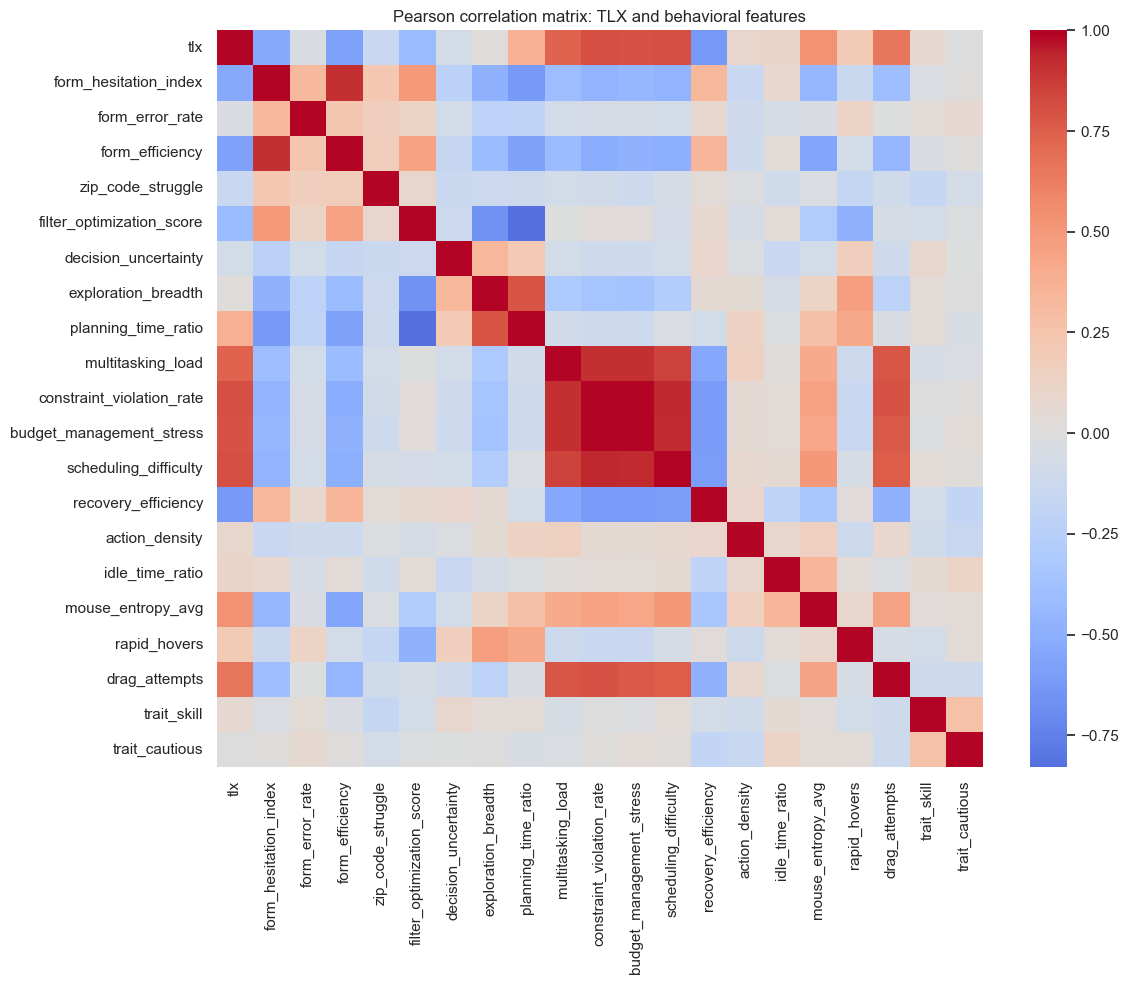

In [7]:

import seaborn as sns
corr_matrix = df[['tlx'] + feature_cols].corr(method='pearson')
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=False)
plt.title('Pearson correlation matrix: TLX and behavioral features')
plt.tight_layout()
plt.savefig('../../analysis/results/correlation_matrix_heatmap.png', dpi=200)
plt.show()


#### Figure: Correlation Heatmap

Pearson correlation matrix between TLX and all engineered behavioral features. Warm colors indicate positive associations (higher workload), cool colors indicate negative associations (lower workload). Saved to `analysis/results/correlation_matrix_heatmap.png`.


The heatmap illustrates the Pearson correlations between TLX and all engineered behavioral features. A clear structure emerges:

Strong positive clusters appear among the Task 3 features
(constraint violation rate, budget management stress, scheduling difficulty, multitasking load),
confirming that higher difficulty in travel planning corresponds to higher workload.

Strong negative associations appear for Task 1 efficiency features, such as
form efficiency and recovery efficiency, indicating that smoother, more efficient behavior relates to lower workload.

Moderate correlations for Task 2 features (filter optimization score, exploration breadth) reflect its intermediate difficulty.

Overall, the heatmap visually reinforces the expected workload gradient across tasks and highlights the behavioral features most tightly linked to cognitive load.

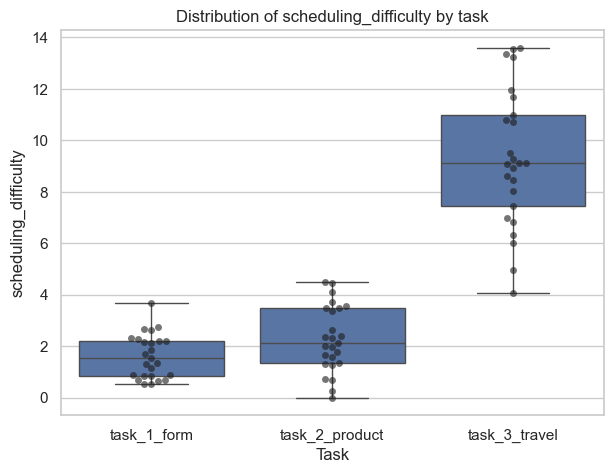

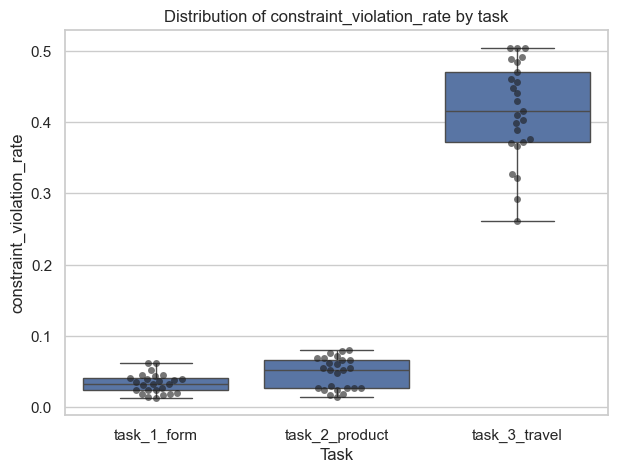

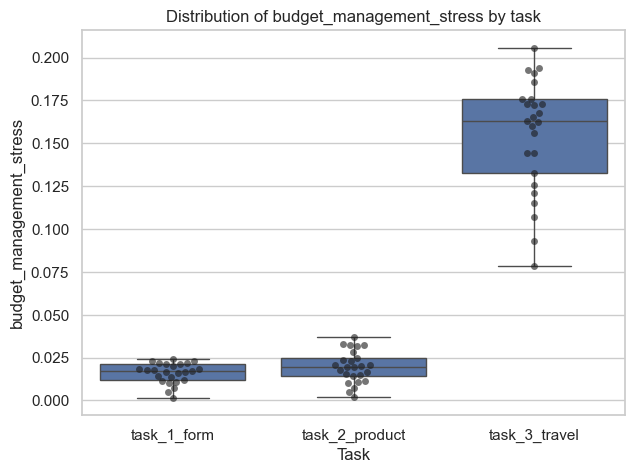

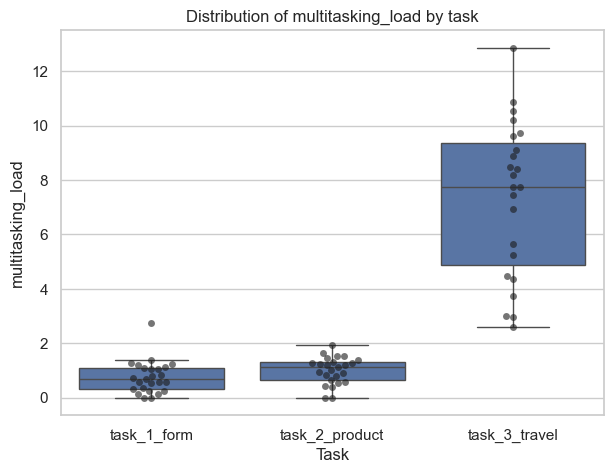

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


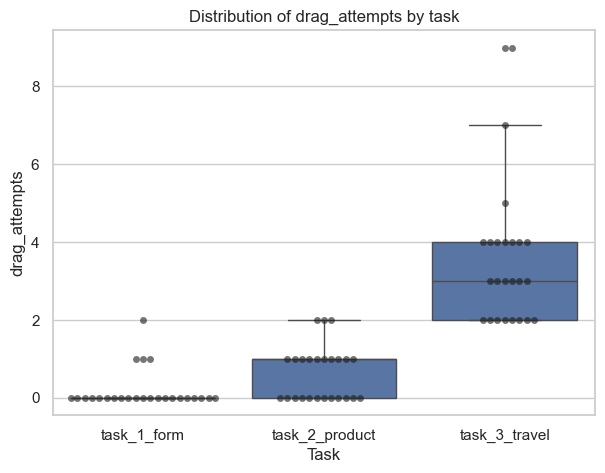

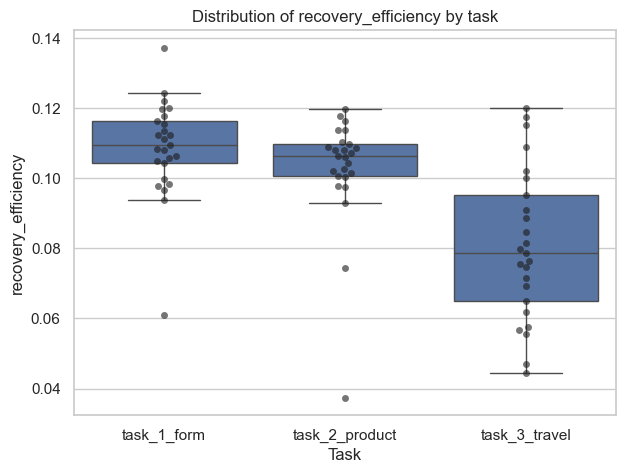

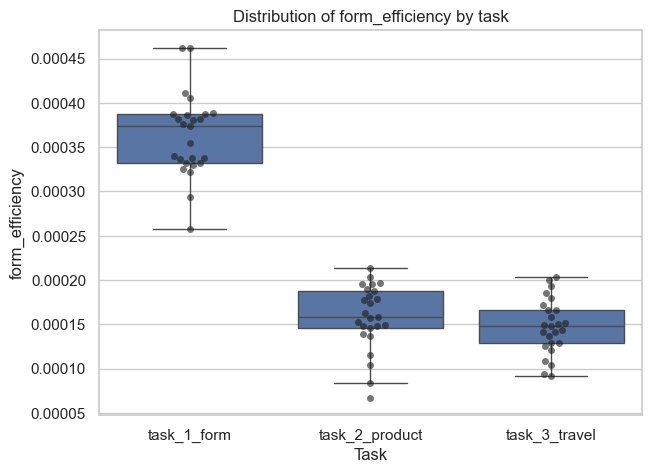

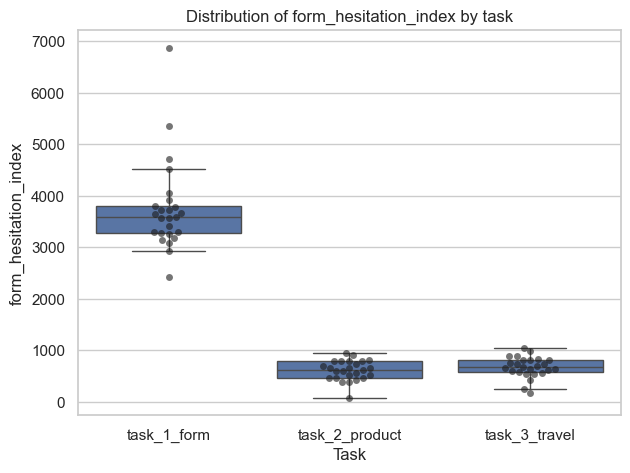

In [8]:

top_feats = pearson_df.head(8)['feature'].tolist()
for feat in top_feats:
    plt.figure(figsize=(7,5))
    order = ['task_1_form','task_2_product','task_3_travel']
    sns.boxplot(x='task_id', y=feat, data=df, order=order, showfliers=False)
    sns.swarmplot(x='task_id', y=feat, data=df, order=order, color='k', alpha=0.6)
    plt.title(f'Distribution of {feat} by task')
    plt.xlabel('Task'); plt.ylabel(feat)
    fname = f'../../analysis/results/boxplot_{feat}.png'
    plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()


#### Figures: Top Feature Distributions by Task

Boxplots with swarm overlays for the top workload-related features across tasks. Elevated distributions in Task 3 (Travel Planning) and lower/efficient distributions in Task 1 (Form Entry) reflect the workload gradient. Files saved as `analysis/results/boxplot_<feature>.png`.


### Feature Distributions Across Tasks

- Task 3 (Travel Planning) shows higher values for difficulty features (e.g., `scheduling_difficulty`, `constraint_violation_rate`, `budget_management_stress`, `multitasking_load`, `drag_attempts`).
- Task 1 (Form Entry) shows lower difficulty but higher efficiency (e.g., higher `form_efficiency`, lower `form_hesitation`).
- Task 2 (Product Exploration) generally lies between Task 1 and Task 3, reflecting its medium-load design.

These patterns visually support the intended cognitive-load hierarchy (Task 1 < Task 2 < Task 3) and highlight the behavioral features that differentiate difficulty levels.


## Discussion & Conclusion

### Summary
The analyses validate a clear workload gradient across tasks. NASA-TLX increases from Task 1 → Task 2 → Task 3, and behavioral features align with this pattern: difficulty-related signals (constraint violations, scheduling difficulty, budget stress, multitasking, drag attempts) rise with workload, while efficiency-related signals (recovery efficiency, form efficiency, lower hesitation) align with lower load.

### Key Takeaways
- Convergent evidence: TLX, correlations, heatmap, and distributions tell a consistent story.
- High-load indicators: Constraint violations, scheduling difficulty, budget stress, multitasking, drag attempts.
- Low-load indicators: Recovery efficiency, form efficiency, lower hesitation.
- Task sensitivity: Effects strengthen from low-load Task 1 to high-load Task 3.

### Implications for Modeling
- Feature selection: Prioritize high-signal features as candidates for modeling and SHAP interpretation.
- Task-aware modeling: Consider including `task_id` or interaction terms; evaluate per-task metrics.
- Validation strategy: Use leave-one-user-out (LOUO) to assess generalization across participants.

### Limitations
- Sample size and scope: N = 75 within-subject observations; generalization beyond these tasks requires caution.
- Collinearity: Some difficulty features may be correlated; monitor variance inflation and redundancy.
- Multiple comparisons: Correlation screening can inflate Type I error; consider p-value adjustment or FDR.

### Next Steps
- Model training: Run LOUO Random Forest and evaluate per-task performance.
- Explainability: Compute SHAP values to verify that model attributions match the correlation-based expectations.
- Robustness checks: Replicate with Spearman, partial correlations controlling for task, and multiple-comparison corrections.
- Reporting: Save a compact table of top features with effect sizes and adjusted p-values for inclusion in the paper.
